# Peak Decoupling through Fitting 
This dataset contains a particle size distribution curve: columns of the volume % and the particle size. In this exercise, I will resolve the overlapping peaks by fitting a sum of two lognormal distributions. By resolving, the mean peak positions of each underlying moiety can be identified.

## Import modules & define formatting

In [1]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
import math
from matplotlib import rcParams
import pandas as pd
size=10

## Define a class to read & get data; store the models for fitting

In [2]:
class AnalyzePSD(object):
    def __init__(self,filename):
        '''input:  filename is of type string, it indicates the name of the file for reading
        Read the file and store it in self.datafile'''
        self.filename=filename
        self.datafile=pd.read_csv(filename,engine='python',sep='\t',header=2)

    def getDataFile(self):
        '''returns the pd.DataFrame of the file that was read in'''
        return self.datafile

    def getVolSize(self):
        '''return the size and volume density data as pd.Series'''
        size=pd.to_numeric(self.datafile['Size Classes (um)'],downcast='float',errors='coerce')
        vol=pd.to_numeric(self.datafile['Volume Density (%)'],downcast='float',errors='coerce')
        return size,vol

    def Pmod(self,x,sigma,mu,c):
        '''define a function to contain the log normal model'''
        denom1=x*sigma*(2*math.pi)**(1/2)
        expterm=((np.log(x)-mu)/sigma)**2
        Ptot=c*(np.exp(-.5*expterm)/denom1)
        return Ptot

    def PmodBimodal(self,x,sigma,mu,c,sigma2,mu2,d):
        '''define a function to contain a bimodal log normal model'''
        denom1=x*sigma*(2*math.pi)**(1/2)
        denom2=x*sigma2*(2*math.pi)**(1/2)
        expterm=((np.log(x)-mu)/sigma)**2
        expterm2=((np.log(x)-mu2)/sigma2)**2
        Ptot=c*(np.exp(-.5*expterm)/denom1)+d*(np.exp(-.5*expterm2)/denom2)
        return Ptot

## Define a Graph object for graphing and formatting

In [3]:
class Graph(object):
    def __init__(self,fx,fy):
        '''input:  fx and fy are type integers--they are the dimensions of the figure'''
        self.fx=fx
        self.fy=fy
        fig=plt.figure(figsize=(fx,fy),dpi=300)
        
    def graphPSD(self,x,y,sym,clr,samp):
        '''x and y are of the same length (pd.Series type)
        sym is type string identifying the marker symbol
        clr is type string, denoting the color for the marker
        samp is type string, naming the name of the data series for the legend'''
        plt.semilogx(x,y,sym,color=clr,markersize=3,mec=clr,label=samp)
        plt.xlabel('Size ($\mu$m)',fontsize=size)
        plt.ylabel('Volume Density (%)', fontsize=size)
        return
    
    def formatGraph(self):
        '''format the Graph to have ticks on all sides
        incorporate a legend
        and ensure that everything fits inside the dimensions previously noted'''
        plt.tick_params(labelsize=size)
        plt.tick_params(which='major',right='on',direction='in',top='on',length=6)
        plt.tick_params(which='minor',right='on',direction='in',top='on',length=3)
        plt.legend(loc='best',fontsize=size-5)
        plt.tight_layout()
        return

## Call the file and read the data

In [4]:
file='PSD_Sample1.txt'
dataSet=AnalyzePSD(file)    #instantiate an object of AnalyzePSD
psize,vol=dataSet.getVolSize()
psizefit=psize[34:59]           #select the region for fitting
volfit=vol[34:59]                   #select the region for fitting

In [5]:
dataSet.PmodBimodal

<bound method AnalyzePSD.PmodBimodal of <__main__.AnalyzePSD object at 0x7f6228552210>>

## Run the fit using curve_fit from SciPy

In [17]:
popt,pcov=curve_fit(dataSet.PmodBimodal,psizefit,volfit)

## Print the results to the fit

In [19]:
print('The results from the fit to the log normal')
print('\nsigma=', popt[0],', mu=',popt[1], ', c=', popt[2],'sigma2=',popt[3],', mu2=',popt[4],', d=',popt[5])

The results from the fit to the log normal

sigma= 1.0 , mu= 1.0 , c= 1.0 sigma2= 1.0 , mu2= 1.0 , d= 1.0


## Plot the data and the results from the model


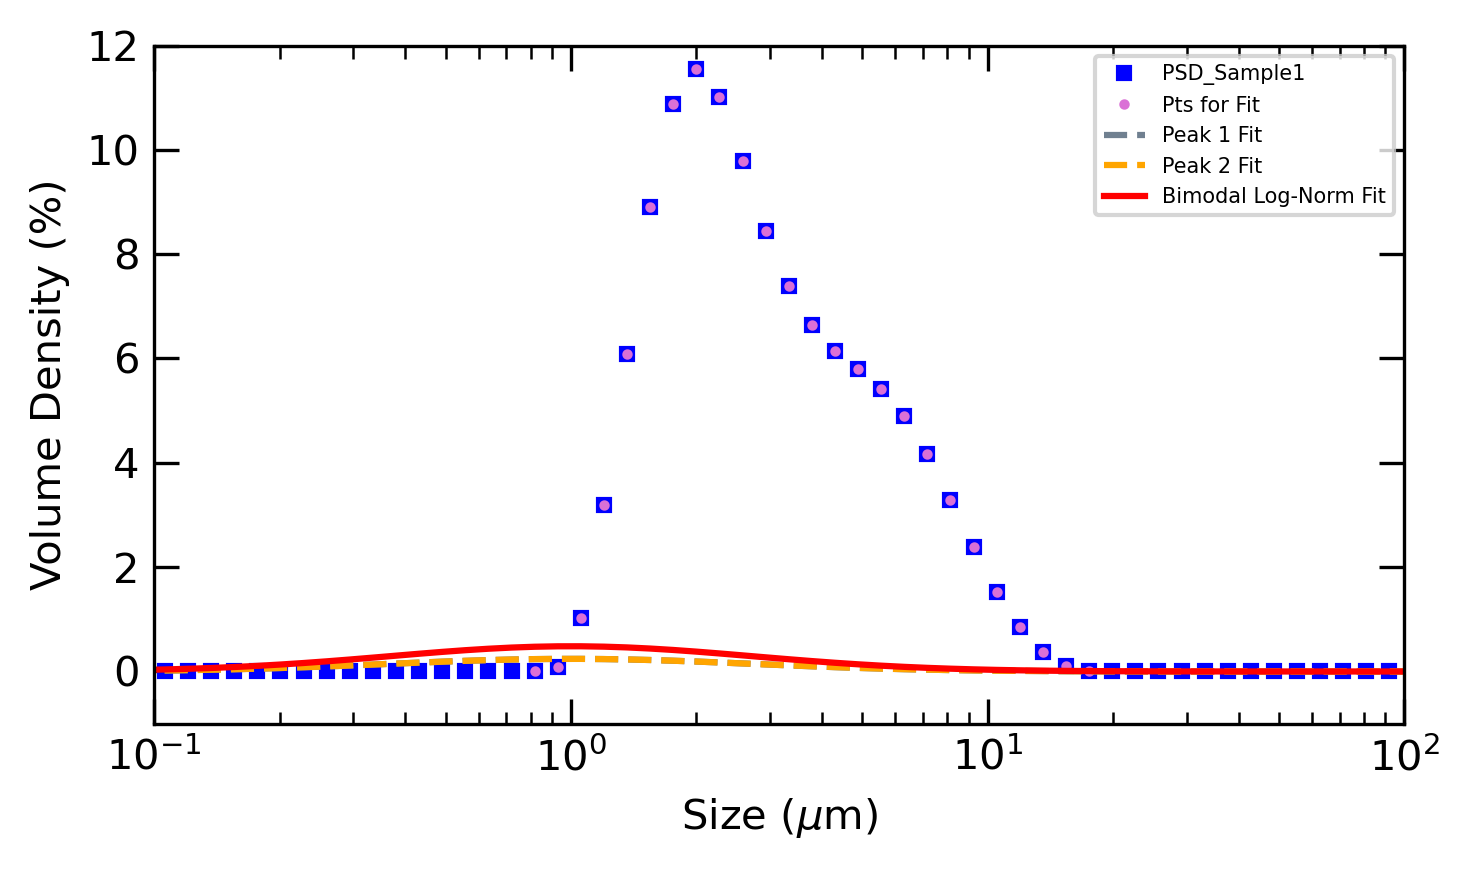

In [18]:
fig1=Graph(5,3)
fig1.graphPSD(psize,vol,'s','b',file[:-4])   # this is the whole curve
fig1.graphPSD(psizefit,volfit,'.','orchid','Pts for Fit')
#
fig1.graphPSD(psize,dataSet.Pmod(psize,popt[0],popt[1],popt[2]),'--','slategrey','Peak 1 Fit')
fig1.graphPSD(psize,dataSet.Pmod(psize,popt[3],popt[4],popt[5]),'--','orange','Peak 2 Fit')
fig1.graphPSD(psize,dataSet.PmodBimodal(psize,*popt),'-','r','Bimodal Log-Norm Fit')
plt.axis([.1,100,-1,12])
fig1.formatGraph()
plt.show()

## Determine the mean sizes of each Peak
From the graph above, the peak was resolved into two peaks.  What is the mean particle size associated with each of those peaks?

The following calculations will calculate the means for peak 1 and peak 2.  

First, find the area under the curve for each resolved peak:

In [9]:
area1=np.trapz(dataSet.Pmod(psize,popt[0],popt[1],popt[2]),psize)
area2=np.trapz(dataSet.Pmod(psize,popt[3],popt[4],popt[5]),psize)

Next, determine the cumulative sum of the y values in the distribution.  That is, the cumulative sum of the volume density.  

In [10]:
sum1=dataSet.Pmod(psize,popt[0],popt[1],popt[2]).sum()
sum2=dataSet.Pmod(psize,popt[3],popt[4],popt[5]).sum()

Normalize each function to the area such that the sum of the y-values equals 1

In [11]:
norm1=(dataSet.Pmod(psize,popt[0],popt[1],popt[2])/sum1)
norm2=(dataSet.Pmod(psize,popt[3],popt[4],popt[5])/sum2)

normsum1=norm1.sum()
normsum2=norm2.sum()

Now the mean of each peak can be determined:

In [12]:
weighted1=(psize*norm1).sum()
weighted2=(psize*norm2).sum()

print('The mean sizes of each peak are the following: peak 1 =',round(weighted1,2), 'um and peak 2 = ',round(weighted2, 2), 'um.')

The mean sizes of each peak are the following: peak 1 = 1.65 um and peak 2 =  1.65 um.


## Correlation Coefficient of Fit:  R-squared
Finally, how do we quantify how good the fit was to the data? 
This can be represented by the correlation coefficient.  The closer it is to a value, the better the fit. 

First, determine the residuals:  the difference between the ydata and the yvalues from the fit. 

In [13]:
residuals=volfit-dataSet.PmodBimodal(psize,*popt)

Next, square the residuals, and compute its sum.

In [14]:
residual_sum_squares=np.sum(residuals**2)

Next, determine the sum of the squares of the data. 

In [15]:
total_sum_squares=np.sum((volfit-np.mean(volfit))**2)

Finally, the correlation coefficient can be determined through the following. 

In [16]:
r_squared=1-(residual_sum_squares/total_sum_squares)
print('\nR-squared=',round(r_squared,3))


R-squared= -1.45


Based on the r-squared value, it can be concluded that the fit is a good representation of the data shown herein.